<a href="https://colab.research.google.com/github/toliyang/AI_ML/blob/main/MLFlow/MLFlow_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLFlow and Hyperparameter Optimization

For the second workshop on AI for the Electron Ion Collider.

https://indico.bnl.gov/event/16586/

October 12th, 2022

Diana McSpadden


## Intro

<a href="https://mlflow.org/" target="_new">MLFlow</a> is an open-source platform for the machine learning lifecycle. MLFlow divides the machine learning lifecycle into four components:
1. Experimentation: MLFlow Tracking
1. Reproducibility: MLFlow Projects
1. Deployment: MLFlow Models
1. Central Registry for versioning, annotating, and managing a repository of models: MLFlow Model Registry

This tutorial provides example code to package machine learning hyperparameter optimization (HPO) in a reusable and reproducible format. This demonstrates the **MLFlow Tracking** component.

While this tutorial includes data science techniques and neural network models, this example is **not intended** to explain the techniques thoroughly. You **will** be able to develop models with higher accuracy. Please do. This tutorial will help you **track** all the methods you attempt, compare the results, and reproduce those results.

Additionally, this tutorial will use the **hyperopt** (https://github.com/hyperopt/hyperopt) library for hyperparameter optimization.

Discussion of hyperparameter tuning algorithms is outside the scope of this tutorial. Suffice it to say that we want to try to identify the best model hyperparameters from an identified set, or range of hyperparameters.

**MLFlow Model Registry** can be used for versioning, annotating, and serving a trained machine learning model. We won't have time to go over the model registry, but the MLflow functionality supports a REST API interface for getting predictions from a registered model.

### Notebook settings - if using Google Drive check for GPUs:

1. Menu -> Runtime -> Change Runtime Type
1. check that GPUs are enables (you won't really need them for the sequential neural net, but the CNN gets a bit slow for a tutorial without them enabled)




### Import Libraries

In [ ]:
import sys, os

import pandas as pd
# set display settings to see larger dataframes
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import numpy as np

# these two lines are to address the writable directory warning from matplotlib
os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"
# end two lines

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# import time to track time to train and predict
import time

# import tensor flow packages
from tensorflow import keras
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# libraries for scaling/normalizing variables
from sklearn.preprocessing import MinMaxScaler, StandardScaler


#### Install/Import MLFlow

You will need to pip install mlflow into your environment to see the benefits of tracking hyperparameter optimization using MLFlow.

* Uncomment the following line
* execute it
* comment it out again if you would like your display to be cleaner
* execute it again

#### **If you are logged into a Google account**
you can connect to your Google Drive IF you would like to install mlflow for reuse. I recommend this in case your Google Colab session expires.


In [ ]:
import sys, os
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
nb_path = '/content/notebooks'

# comment out next line second time you run this code block in the same session
#os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)


sys.path.insert(0,nb_path)

Mounted at /content/drive


**Install mlflow library, either to your Google drive, or only for your session**

**You will need to restart your notebook after installation**

In [ ]:
## normal pip install will require you to run install with each new session
#!pip install mlflow
## if you are logged into your Google account
##   you can save the mlflow install to your Google drive
#!pip install --target=$nb_path mlflow

**And,** import mlflow

In [ ]:
import mlflow

In [ ]:
# this code is here so I can pause and talk without the Colab session disconnecting
#while True:pass

### The Tutorial Problem

This example uses the "Problem 1" dataset from Jefferson Lab's 2021 AI Townhall Hackathon.

 If you are interested you can read more about the hackathon here: <https://halldweb.jlab.org/Hackathon2021/HackathonLinks.html> and here: <https://docs.google.com/document/d/1hgrB2y8J_z2t9dmaFTbqFFTHkI5i6fb25oPSZyGB63A/edit#>


 All the datasets can be found here: <https://userweb.jlab.org/~tbritton/Hackathon2021_DataSets/>

**Single shower calorimeter: amplitude and localtion**:

In this problem, the calorimeter has a single shower where the energy is distributed through multiple blocks. The shower center can be anywhere in the calorimeter ( –1000 < x,y < +1000 ) and will never be outside that. However, energy from the shower that falls outside the calorimeter is lost.  The solution to this problem will be three values:
1. shower amplitude
1. x-coordinate of shower center
1. y-coordinate of shower center

The showers here are “clean” with no noise or background.

For this example, the data comes in a CSV format where the 900 energy deposition values are stored directly in the CSV file. The last three columns are the labels: (amp, X, Y). Thus, there are 903 columns and each row represents a different event.




### Helpful Functions

Below are four functions useful for the problem:

**retrieve_X_df**: retrieves the input variable columns from the CSV and returns a pandas dataframe containing the columns.


**retrieve_y_df**: retrieves the target columns from the CSV and returns a pandas dataframe containing the columns.


**turn_rows_into_np_matrix**: input is the dataframe and the "width" and "height" of the matrix representation of an image that is represented by each row in the dataframe.


**create_scaler**: creates a selected scaler type (StandardScaler is the default. MinMax is also supported) and returns the scaler and the scaled data

**createTrainTestHistograms**: plots histograms of each of the target variables.

In [ ]:
# get the problem 1 files
def retrieve_X_df(df, verbose=True):
  """
  :param df: Required, the dataframe containing the input and output variables. The first 900 values for each observation are assumed the input variables.
  :param verbose: Optional, default==True, prints the shape of the dataframe after retrieving the input columns.

  :return: dataframe containing the input data.
  """
  df = df.iloc[:,0:900]
  if verbose:
    print("df shape: ", df.shape)
  return df

def retrieve_y_df(df, n_last_cols = 3, verbose=True):
  """
  :param df: Required, the dataframe containing the input and target variables.
  :param n_last_cols: Optional, default==3, The number of column values for each observation that are the target variables.
  :param verbose: Optional, default==True, prints the shape of the dataframe after retrieving the target columns.

  :return: dataframe containing the target data.
  """
  df = df.iloc[:,-n_last_cols:]
  df.columns = ['amplitude','X','Y']
  if verbose:
    print("df shape: ", df.shape)
  return df

def turn_rows_into_np_matrix(df, width=30, height=30,verbose=True):
  """
  :param df: Required, the dataframe containing the input variables.
  :param width: Optional, default==30, The width to use when transforming a 1-D representation of data to 2-D representation.
  :param height: Optional, default==30, The height to use when transforming a 1-D representation of data to 2-D representation.
  :param verbose: Optional, default==True, opperate in verbose mode.

  :return: numpy ndarray shape(n_observations, width, height)
  """
  # save the dataframe as a numpy arrray
  np_img_matrices = df.to_numpy()
  if (verbose):
    print("len numpy array: ", len(np_img_matrices))

  # for each row, turn into a width x height matrix using the shape method
  # set the shape
  shape = (len(np_img_matrices),width,height)
  # re shape the array
  np_img_matrices = np_img_matrices.reshape(shape)

  if verbose:
    # print the first "image" matrix
    print(np_img_matrices[0])

  return np_img_matrices

# create a scaler for data and scale the data - return both the scaler and the scaled data
def create_scaler(data, scaler_type="Standard"):
  """
  :param data: Required, array-like of shape (n_observations, n_variables).
  :param width: Optional, default=='Standard', valid values ['Standard','MinMax']. Which of the scikit-learn scalers to use to scale the data.
    https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
    https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

  :return: scaler object, scaled data
  """
  # default scaler to StandardScaler
  scaler = StandardScaler()

  if scaler_type == "MinMax":
    scaler = MinMaxScaler()

  scaler.fit(data)
  scaled_data = scaler.transform(data)

  return scaler, scaled_data

def createTrainTestHistograms(train_y, test_y, index, featurename, bins = 20):
  """
  plots histograms of a target variables from the train and test sets.

  :param train_y: Required, array-like of shape (n_observations, n_target_variables (in our case, 3)).
  :param test_y: Required, array-like of shape (n_observations, n_target_variables (in our case, 3)).
  :param index: Required, index of n_target_variables to plot
  :param featurename: Required, name of the target feature for the x-axis of the plot
  :param bins: Optional, default==20
  """
  fig, ax = plt.subplots(1,2,figsize=(10, 3))
  ax[0].hist(train_y[:,index], bins, alpha = 0.5, color = 'g', density=True)
  ax[0].set_title("Train")
  ax[0].set_xlabel(featurename)
  ax[0].set_ylabel('count')
  ax[1].hist(test_y[:,index], bins, alpha = 0.5, color = 'r', density=True)
  ax[1].set_title("Test")
  ax[1].set_xlabel(featurename)
  ax[1].set_ylabel('count')
  plt.show()


Retrieve the train and test datasets.

Use the retrieve_X_df(), and retrieve_y_df(.) methods.

In [ ]:
# csv versions of the data
# train
# https://userweb.jlab.org/~tbritton/Hackathon2021_DataSets/Problem1/train.csv
df_train = pd.read_csv('https://userweb.jlab.org/~tbritton/Hackathon2021_DataSets/Problem1/train.csv', header=None)
df_train_X = retrieve_X_df(df_train)
train_y = retrieve_y_df(df_train).to_numpy()

# test
# https://userweb.jlab.org/~tbritton/Hackathon2021_DataSets/Problem1/test.csv
df_test = pd.read_csv('https://userweb.jlab.org/~tbritton/Hackathon2021_DataSets/Problem1/test.csv', header=None)
df_test_X = retrieve_X_df(df_test)
test_y = retrieve_y_df(df_test).to_numpy()

df shape:  (10000, 900)
df shape:  (10000, 3)
df shape:  (2000, 900)
df shape:  (2000, 3)


#### Exploratory Data Analysis (EDA)
1. Confirm X, Y, amplitude are similar in train and test sets.
We are assuming our obserations are independent.

1. Check that our targets are similarly distributed between our train and test sets. Different distributions of data in train and test may be challenging to learn.

Plot Amplitude:


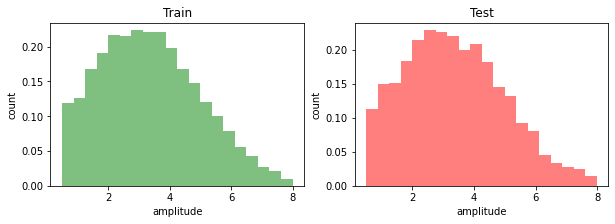

Plot X:


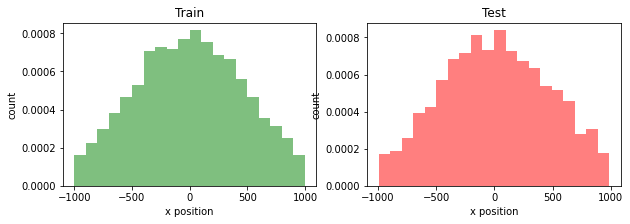

Plot Y:


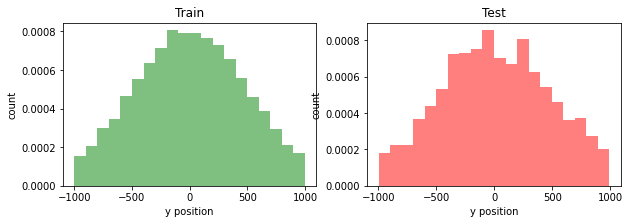

In [ ]:
# plot the distributions of the normalized counts of the target variables in the train and test sets to ensure the distribuions are similar
print("Plot Amplitude:")
# plot amplitude
createTrainTestHistograms(train_y, test_y, index = 0, featurename='amplitude')
print("Plot X:")
# plot x position
createTrainTestHistograms(train_y, test_y, index = 1, featurename='x position')
print("Plot Y:")
# plot y position
createTrainTestHistograms(train_y, test_y, index = 2, featurename='y position')

In addition to distributions, take a look at correlations between targets variables.

In other words, are x, y, or amplitude correlated with each other. This answer impacts the modeling techniques one should select.

<AxesSubplot:>

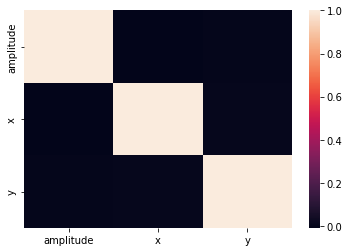

In [ ]:
import seaborn as sns

# calculate the correlation matrix of the last 3 columns: x, y, and amplitude
corr_train = df_train[[900,901,902]].corr()

# plot the heatmap
sns.heatmap(corr_train,
        xticklabels=['amplitude','x','y'],
        yticklabels=['amplitude','x','y'])



<AxesSubplot:>

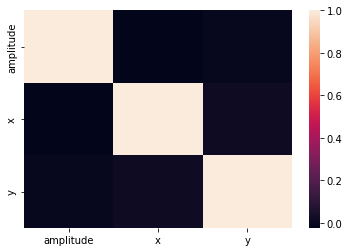

In [ ]:
# calculate the correlation matrix of the last 3 columns: x, y, and amplitude
corr_test = df_test[[900,901,902]].corr()

# plot the heatmap
sns.heatmap(corr_test,
        xticklabels=['amplitude','x','y'],
        yticklabels=['amplitude','x','y'])

This 3 targets are not correlated.

#### Turn the rows into matrices and visualize the first image.

In [ ]:
train_X = turn_rows_into_np_matrix(df_train_X, 30,30, False)
print(train_X.shape)
test_X = turn_rows_into_np_matrix(df_test_X, 30,30, False)
print(test_X.shape)

(10000, 30, 30)
(2000, 30, 30)


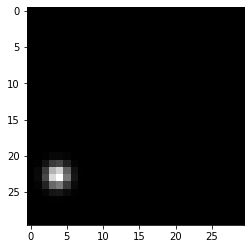

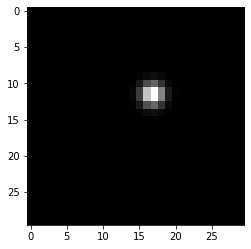

In [ ]:
# show a train matrix as an image
# select a random number between 0 and 9999
from random import randint

# select a random number between the indices of train_X samples to display
plt.imshow(train_X[randint(0, 9999)], cmap='gray')
plt.show()

# select a random number between the indices of test_X samples to display
# select a random number between 0 and 1999
plt.imshow(test_X[randint(0, 1999)], cmap='gray')
plt.show()

In [ ]:
# this code is here so I can pause and talk without the Colab session disconnecting
#while True:pass

### Try Two Model Architectures

We want to try to build the a model to identify the amplitude, and X and Y coordinates of the shower.

#### Open questions:
1. Will a simple sequential neural net work?
1. What about a convolutional neural network?
1. What batch size?
1. What learning rate?
1. How many layers?
1. How many nodes per layer?
1. etc...


### Let's begin by writing two functions:
1. to create a convolutional neural network (CNN) with:
  * configurable "image" width, height, depth.
  * configurable numbers of filters
  * configurable activations
  * configurable dropout percentage
  * a configurable number of outputs
1. a basic sequential neural network:
  * configurable input dimensions (width)
  * configurable number of nodes per layer
  * configurable activations per layer
  * configurable number of outputs



In [ ]:
# create a CNN with selected parameters
def create_cnn(width,height,depth,filters=(16, 32, 64),activations=('relu','relu','relu'),dropout=0.2,outputs=3):
  """
  creates a basic convolutional neural network for images of width x height x depth (channels).
  Each CNN "layer"  is a Conv2D + Activation + Batch Normalization + MaxPooling2D
  Length of filters tuple must be the same as the length of the activation tuple
  The length of the filters and activations tuples will be the number of (CONV => RELU => BN => POOL)

  :param width, height, depth: shape attributes of the image data.
  :param filters: tuple of the filter number to use for each layer
  :param activations: tuple of activations to use for each layer
  :param dropout: help your network generalize and not overfit. neuron's in a layer have a dropout probability will not connect with the next layer.
  :param outputs: number of outputs to the CNN
  """
  # initialize the input shape and channel dimension, assuming
  # TensorFlow/channels-last ordering
  inputShape = (height, width, depth)
  chanDim = -1

  if len(filters) != len(activations):
    print('The length of the filters array and activations array must be the same.')
    sys.exit()

  # define the model input
  inputs = Input(shape=inputShape)
  # loop over the number of filters
  for (i, f) in enumerate(filters):
    # if this is the first CONV layer then set the input
    # appropriately
    if i == 0:
      x = inputs
    # Example: CONV => RELU => BN => POOL
      # f = # filters to learn
      # kernel_shape is (3,3): (required tuple or list of 2 integers) specifies the kernel size of the convolution along the width and height. (3,3) is a typical value

    x = Conv2D(f, (3, 3), padding="same")(x)
    x = Activation(activations[i])(x)
    x = BatchNormalization(axis=chanDim)(x) # each "neuron’s" output follows a standard normal distribution across the batch.
    x = MaxPooling2D(pool_size=(2, 2))(x) # reduces the spatial dimensions of the output

  # flatten the volume, then Fully Connected(FC) (16 nodes) => RELU => BN => DROPOUT
  x = Flatten()(x)
  x = Dense(16)(x)
  x = Activation("relu")(x)
  x = BatchNormalization(axis=chanDim)(x)
  x = Dropout(dropout)(x)
  # apply another FC layer
  x = Dense(4)(x)
  x = Activation("relu")(x)

  x = Dense(outputs, activation="linear")(x)
  # construct the CNN
  model = Model(inputs, x)
  # return the CNN
  return model

# sequential neural network with selected parameters
def create_sequential_dnn(width, num_nodes=(16, 16, 16), activations=('relu','relu','relu'),outputs=1):

  model = Sequential()

  if len(num_nodes) != len(activations):
    print('The length of the number of nodes array and activations array must be the same.')
    sys.exit()

  # loop over the number of nodes
  for (i, n) in enumerate(num_nodes):
    # appropriately add layers
    if i == 0:
      model.add(Dense(n, activation=activations[i], input_dim=width))
    else:
      model.add(Dense(n, activation=activations[i]))

  # output
  model.add(Dense(outputs, activation="linear"))

  # return the CNN
  return model

#### And let's scale our data using our helper function:

In [ ]:
# create a scaler and scaled version of train_y
scaler_y, scaled_train_y = create_scaler(train_y, "MinMax", )
# scale test_y with train scaler
scaled_test_y = scaler_y.transform(test_y)

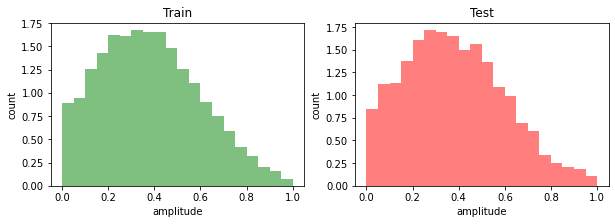

In [ ]:
# plot amplitude histogram after scaling showing MinMax range of between 0 and 1
createTrainTestHistograms(scaled_train_y, scaled_test_y, index = 0, featurename='amplitude')

In [ ]:
# this code is here so I can pause and talk without the Colab session disconnecting
#while True:pass

#### Convolutional Neural Net

Let's try the convolutional neural network

We don't know the best model architecture or hyperparameters; let's try something.

[INFO] training model to predict  amplitude
Epoch 1/10
157/157 [==============================] - 18s 9ms/step - loss: 0.4960 - val_loss: 0.2259
Epoch 2/10
157/157 [==============================] - 1s 8ms/step - loss: 0.1412 - val_loss: 0.1772
Epoch 3/10
157/157 [==============================] - 1s 9ms/step - loss: 0.0904 - val_loss: 0.1094
Epoch 4/10
157/157 [==============================] - 2s 10ms/step - loss: 0.0637 - val_loss: 0.0575
Epoch 5/10
157/157 [==============================] - 2s 10ms/step - loss: 0.0479 - val_loss: 0.0320
Epoch 6/10
157/157 [==============================] - 2s 10ms/step - loss: 0.0356 - val_loss: 0.0233
Epoch 7/10
157/157 [==============================] - 2s 12ms/step - loss: 0.0280 - val_loss: 0.0203
Epoch 8/10
157/157 [==============================] - 2s 11ms/step - loss: 0.0240 - val_loss: 0.0160
Epoch 9/10
157/157 [==============================] - 2s 11ms/step - loss: 0.0200 - val_loss: 0.0128
Epoch 10/10
157/157 [============================

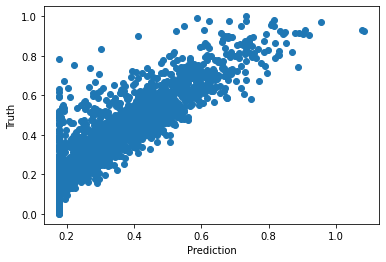

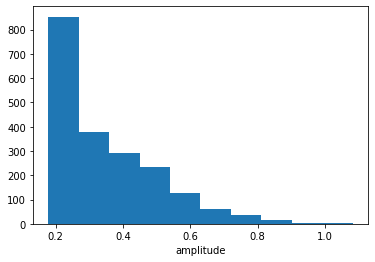

In [ ]:
# target variables
lst_targets = ['amplitude']

# TODO: add the other targets to the list if you would like to see how a model performs for the other targets

for i,target in enumerate(lst_targets):

    # create the model
    # depth is 1 because we are grayscale
    model = create_cnn(width=30, height=30, depth=1, filters=(8,8,8), activations=('relu','relu','relu'), dropout=0.2,outputs=1)
    # vanilla Adam optimizer
    opt = Adam(learning_rate=1e-3)
    model.compile(loss="mse", optimizer=opt)

    # train the model
    print("[INFO] training model to predict ", target)

    early_stopping_monitor = EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=5,
        verbose=True,
        mode='auto',
        baseline=None,
        restore_best_weights=True
    )

    # vanilla fit - feel free to add elements
    model.fit(x=train_X, y=scaled_train_y[:,i],
        validation_data=(test_X, scaled_test_y[:,i]),
        epochs=10, batch_size=64, callbacks=[early_stopping_monitor])


    print("[INFO] predicting...")
    preds = model.predict(test_X)

    print(target, " mean absolute error: ", np.mean(np.abs(scaled_test_y[:,i] - preds.flatten())))
    print(target, " mse: ",np.mean(((scaled_test_y[:,i] - preds.flatten()))**2))

    # plot truth v pred
    plt.scatter(preds, scaled_test_y[:,i])
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.show()
    # plot histogram of predictions to compare to the actual hisotgram of true values
    plt.hist(preds)
    plt.xlabel(target)
    plt.show()

#### Sequential DNN

Create the sequential deep neural net version to solve the problem.

We don't know the best number of layers or nodes, the best activations, or learning rate. But, let's try something.

[INFO] training model to predict  amplitude
Epoch 1/10
157/157 [==============================] - 3s 7ms/step - loss: 0.0195 - val_loss: 0.0019
Epoch 2/10
157/157 [==============================] - 1s 4ms/step - loss: 9.7105e-04 - val_loss: 5.8174e-04
Epoch 3/10
157/157 [==============================] - 1s 4ms/step - loss: 5.0068e-04 - val_loss: 3.8156e-04
Epoch 4/10
157/157 [==============================] - 1s 4ms/step - loss: 3.1952e-04 - val_loss: 3.2259e-04
Epoch 5/10
157/157 [==============================] - 1s 4ms/step - loss: 2.8218e-04 - val_loss: 2.6120e-04
Epoch 6/10
157/157 [==============================] - 1s 4ms/step - loss: 2.2217e-04 - val_loss: 2.9463e-04
Epoch 7/10
157/157 [==============================] - 1s 4ms/step - loss: 2.0592e-04 - val_loss: 2.8415e-04
Epoch 8/10
157/157 [==============================] - 1s 4ms/step - loss: 1.8758e-04 - val_loss: 2.1084e-04
Epoch 9/10
157/157 [==============================] - 1s 4ms/step - loss: 2.3353e-04 - val_loss: 1.8

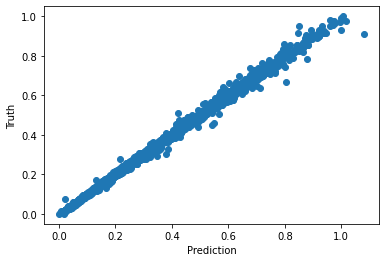

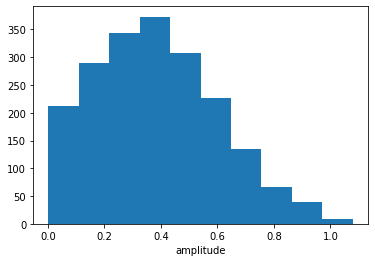

In [ ]:
# let's try the sequential neural network, one for each variable

# target variables
lst_targets = ['amplitude']

# TODO: add the other targets to the list if you would like to see how a model performs for the other targets

for i,target in enumerate(lst_targets):

  # create the model
  # depth is 1 because we are grayscale
  model = create_sequential_dnn(900, num_nodes=(16, 16, 16), activations=('relu','relu','linear'), outputs=1)
  # vanilla Adam optimizer
  opt = Adam(learning_rate=1e-3)
  model.compile(loss="mse", optimizer=opt)

  # train the model
  print("[INFO] training model to predict ", target)

  early_stopping_monitor = EarlyStopping(
      monitor='val_loss',
      min_delta=0,
      patience=3,
      verbose=False,
      mode='auto',
      baseline=None,
      restore_best_weights=True
  )

  # vanilla fit - feel free to add elements
  model.fit(x=df_train_X, y=scaled_train_y[:,i],
      validation_data=(df_test_X, scaled_test_y[:,i]),
      epochs=10, batch_size=64, callbacks=[early_stopping_monitor])


  print("[INFO] predicting...")
  preds = model.predict(df_test_X)

  print(target, " mean absolute error: ", np.mean(np.abs(scaled_test_y[:,i] - preds.flatten())))
  print(target, " mse: ",np.mean(((scaled_test_y[:,i] - preds.flatten()))**2))

  # plot truth v pred
  plt.scatter(preds, scaled_test_y[:,i])
  plt.xlabel('Prediction')
  plt.ylabel('Truth')
  plt.show()
  # plot histogram of predictions to compare to the actual hisotgram of true values
  plt.hist(preds)
  plt.xlabel(target)
  plt.show()

In [ ]:
# this code is here so I can pause and talk without the Colab session disconnecting
#while True:pass

## Pause here:
What if you want to do a grid search over a large number of hyperparameters (filter numbers, activations, dropout, etc) for several model architectures and save accuracy measures and time to train, and any other characteristics of the models?

You **could** create your own system, and share the nomenclature and norms with your data science team, or you could use **MLflow Tracking** which does this for you.

### MLFlow Tracking organizes hyperparameter optimization

#### The machine learning development process.

The process is rife with **experimentation**:
  * different datasets
  * different data preparation techniques
  * different model architectures
  * various software libraries
  * and hyperparameters

Paraphrased from an approachable paper from Zaharia, et al., "Accelerating the Machine Learning Lifecycle with MLflow".
(https://www-cs.stanford.edu/people/matei/papers/2018/ieee_mlflow.pdf)

#### Why Use MLFlow for hyperparameter optimizaton?
1. You have architectures and hyperparameters to evaluate.
1. You would like something more automated than manually tracking ML experiment results. You would like software to do this.
1. You are able to add ~10 lines of code to your current HPO code to track parameters and metrics via MLflow.
1. You want to easily share your model selection and optmization progress with team members.
1. You want to easily share your best model(s) with team members, and stakeholders. - **MLflow Server and Model Registry**


#### MLflow Concepts
MLflow can track, log and/or register the follow:

1. **parameters**: model parameters
1. **metrics**: metrics for a model (during training, and  after training)
1. **artifacts**: output files of any format, including images, pkl'ed models, and data files.

From an MLflow server you can explore registered models, compare model metrics, and access model artifacts.

#### MLflow: "Local" or "Server"
The example here describes using MLFlow "locally" which uses your file system for storage of artifacts, metrics, parameters, and tags.

After this example I will provide screen shots from JLab's MLFlow server  to demonstrate built-in comparisons on the server, and serving a model from the MLFlow model registry.

#### Grid search of hyperparameters on the vanilla deep neural network:

**Create an MLflow Experiment**

MLflow experiments are useful for comparing runs within an experiment. Runs within an experiment are assumed to be attempting to tackle the same task.

Create an experiment, unless the experiment name already exists. If it exists, set to the current experiment.

* create_experiment() - Creates an experiment. (https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.create_experiment)
* set_experiment() - Sets the given experiment as the active experiment. (https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.set_experiment)



### Create MLflow Experiment

In [ ]:
# You will not have access to the JLab MLflow server during the tutorial.
# I leave this code here to show how easy it is to connect to one.
# If you have access to an MLflow server: set to track to the server
MLFLOW_SERVER_URI = ''
mlflow.set_tracking_uri(MLFLOW_SERVER_URI)

In [ ]:
experiment_name = "mlflow_tutorial_calorimeter_amplitude_grid_search"
try:
    experiment_id = mlflow.create_experiment(f"{experiment_name}")
    experiment = mlflow.get_experiment_by_name(f"{experiment_name}")
    mlflow.set_experiment(f"{experiment_name}")
except:
    try:
        experiment = mlflow.get_experiment_by_name(f"{experiment_name}")
        experiment_id = experiment.experiment_id
        mlflow.set_experiment(f"{experiment_name}")
    except Exception as err:
        print(f'error setting experiment: ' + err)

There should now be a directory "mlruns" in the current working directory. Within the mlruns directory are directories for each MLFlow "experiment". Within an experiment's directory is a yaml file. There should be a yaml file with the following keys and similar values:

* artifact_location: file:///content/mlruns/1
* creation_time: 1663962384565
* experiment_id: '1'
* last_update_time: 1663962384565
* lifecycle_stage: active
* name: mlflow_tutorial_calorimeter_amplitude



In [ ]:
print("Name: {}".format(experiment.name))
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))

Name: mlflow_tutorial_calorimeter_amplitude_grid_search
Experiment_id: 748261366657569442
Artifact Location: file:///content/mlruns/748261366657569442
Tags: {}
Lifecycle_stage: active


**Find the mlruns directory** and the two directories within "0" and "1".

Take a look at the .yaml file within the "1" directory.

### Grid Search Example: Sequential Neural Network
Using MLflow to store model metrics from a grid search of hyperparameters.

Epoch 1/10
157/157 [==============================] - 3s 7ms/step - loss: 0.0598 - val_loss: 0.0097
Epoch 2/10
157/157 [==============================] - 1s 4ms/step - loss: 0.0072 - val_loss: 0.0046
Epoch 3/10
157/157 [==============================] - 1s 4ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 4/10
157/157 [==============================] - 1s 4ms/step - loss: 0.0012 - val_loss: 6.3965e-04
Epoch 5/10
157/157 [==============================] - 1s 4ms/step - loss: 5.3857e-04 - val_loss: 3.5132e-04
Epoch 6/10
157/157 [==============================] - 1s 4ms/step - loss: 3.5101e-04 - val_loss: 2.8616e-04
Epoch 7/10
157/157 [==============================] - 1s 4ms/step - loss: 2.8696e-04 - val_loss: 2.2033e-04
Epoch 8/10
157/157 [==============================] - 1s 4ms/step - loss: 2.4170e-04 - val_loss: 2.0107e-04
Epoch 9/10
157/157 [==============================] - 1s 4ms/step - loss: 2.1312e-04 - val_loss: 1.7787e-04
Epoch 10/10
157/157 [==============================] - 1

<ipython-input-61-6a13af8d737b>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Epoch 1/10
157/157 [==============================] - 4s 11ms/step - loss: 0.0268 - val_loss: 0.0038
Epoch 2/10
157/157 [==============================] - 1s 6ms/step - loss: 0.0018 - val_loss: 8.0233e-04
Epoch 3/10
157/157 [==============================] - 1s 6ms/step - loss: 7.0866e-04 - val_loss: 4.9984e-04
Epoch 4/10
157/157 [==============================] - 1s 4ms/step - loss: 4.6007e-04 - val_loss: 3.3692e-04
Epoch 5/10
157/157 [==============================] - 1s 4ms/step - loss: 3.4906e-04 - val_loss: 2.5626e-04
Epoch 6/10
157/157 [==============================] - 1s 4ms/step - loss: 2.7532e-04 - val_loss: 2.3674e-04
Epoch 7/10
157/157 [==============================] - 1s 4ms/step - loss: 2.3302e-04 - val_loss: 1.9978e-04
Epoch 8/10
157/157 [==============================] - 1s 4ms/step - loss: 2.1864e-04 - val_loss: 1.9306e-04
Epoch 9/10
157/157 [==============================] - 1s 4ms/step - loss: 1.8148e-04 - val_loss: 1.9023e-04
Epoch 10/10
157/157 [==================

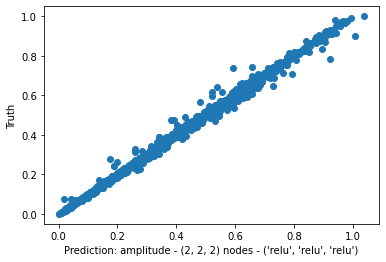

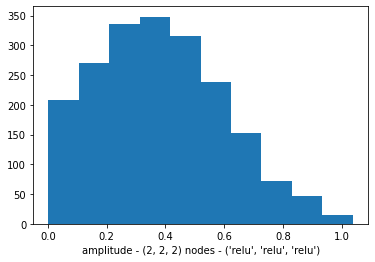

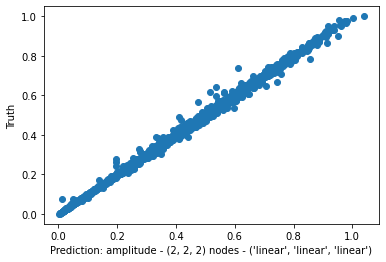

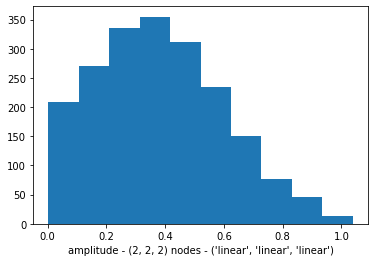

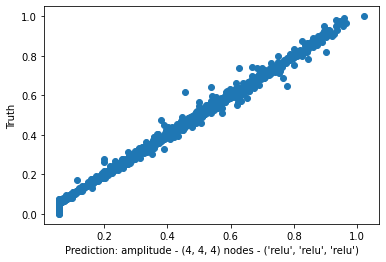

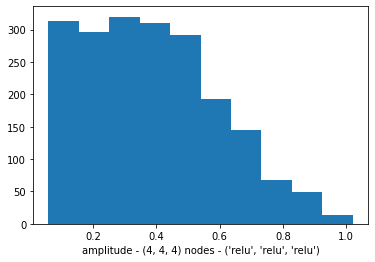

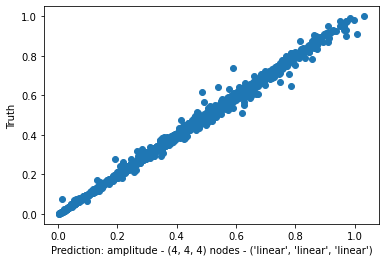

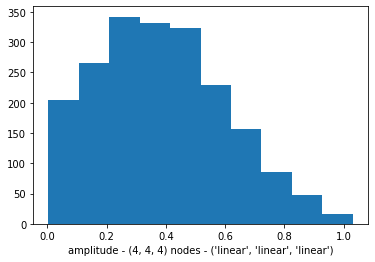

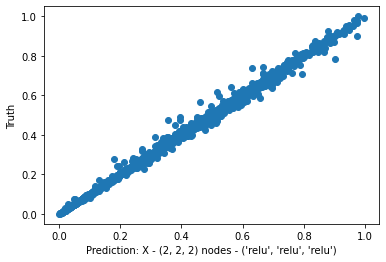

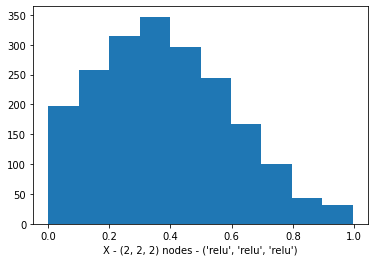

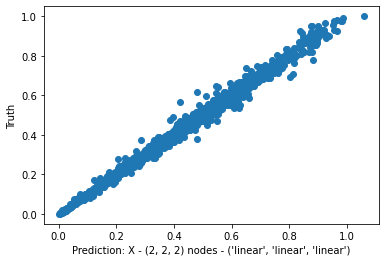

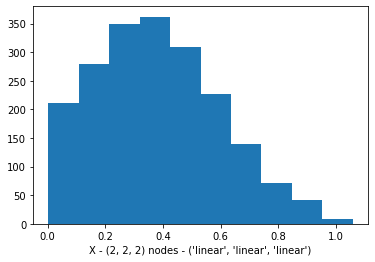

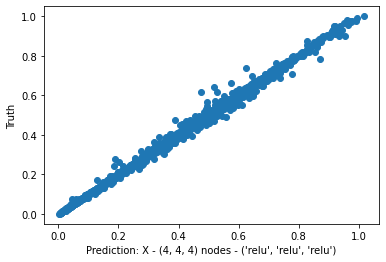

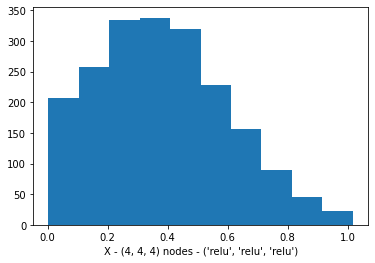

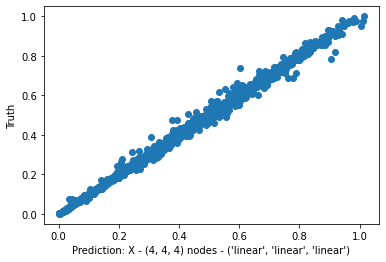

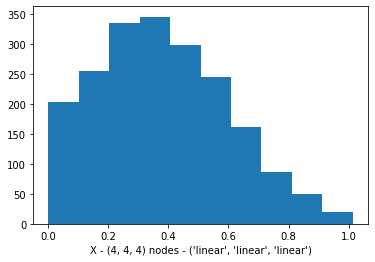

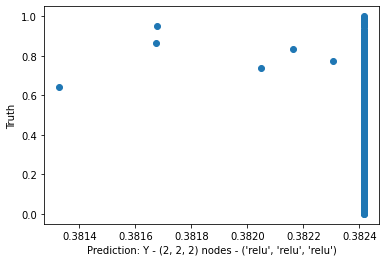

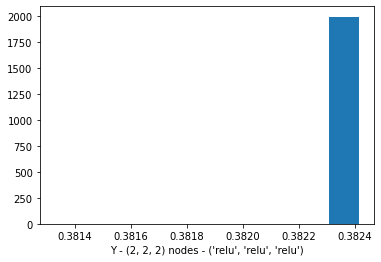

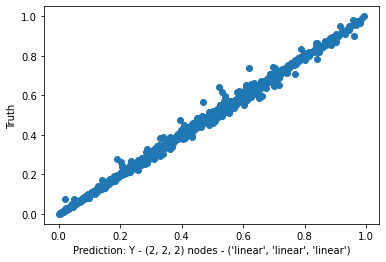

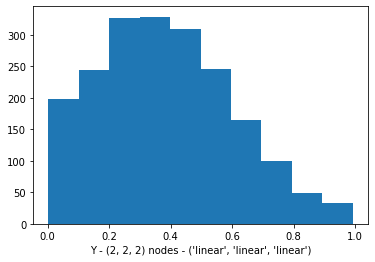

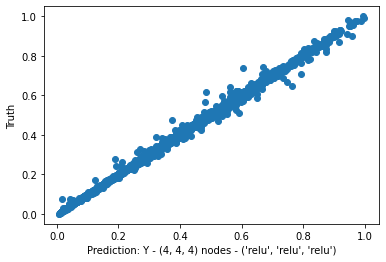

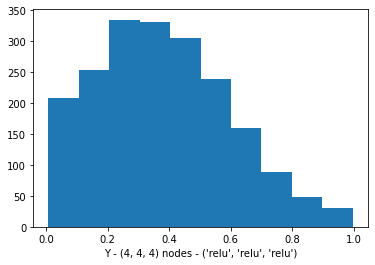

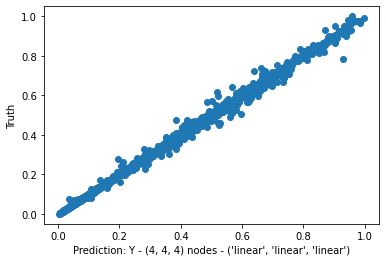

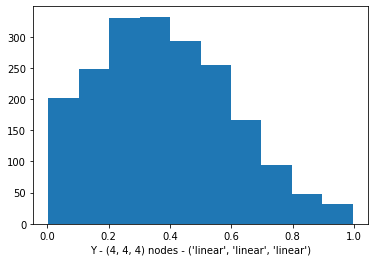

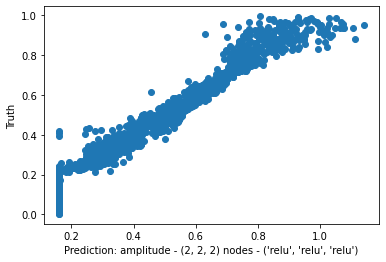

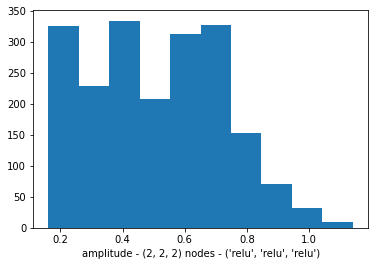

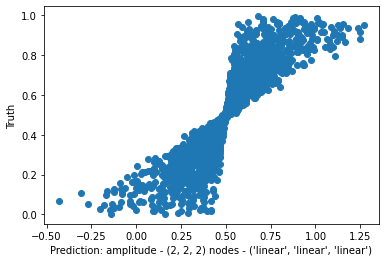

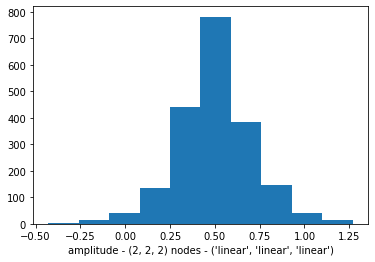

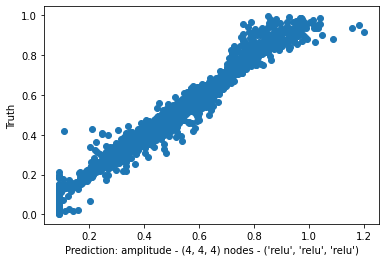

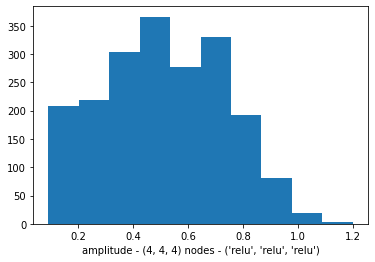

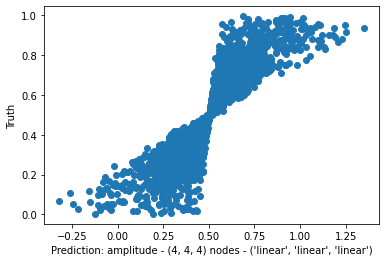

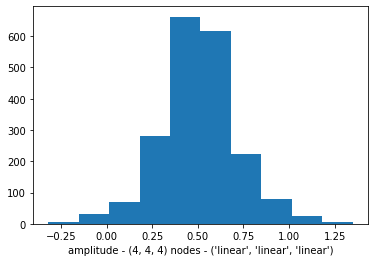

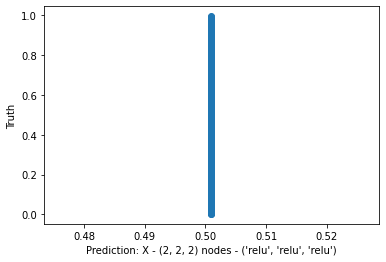

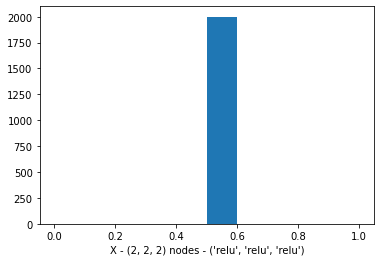

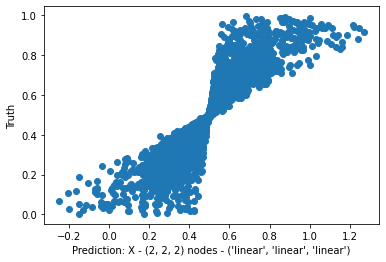

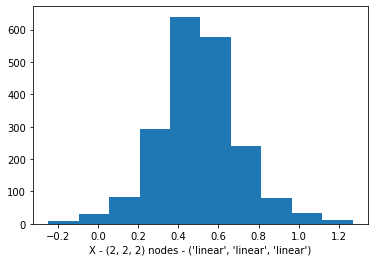

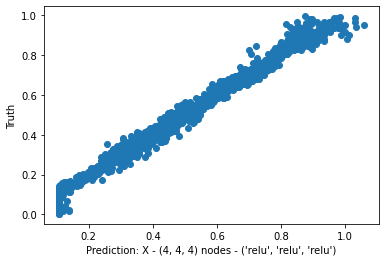

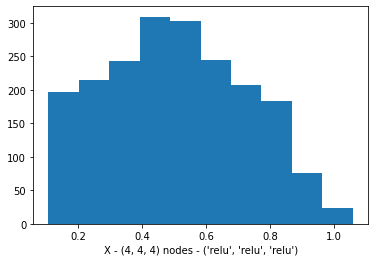

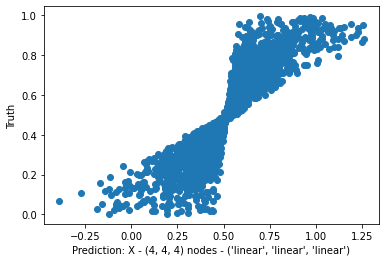

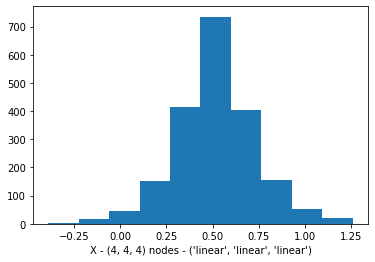

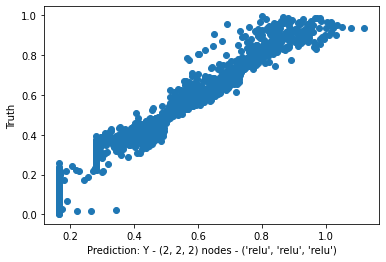

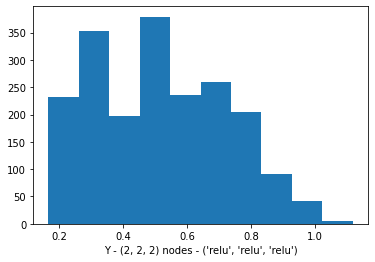

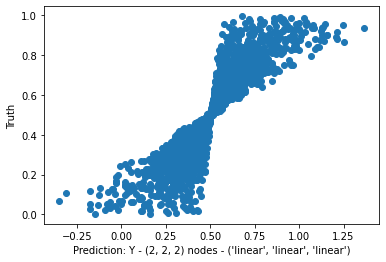

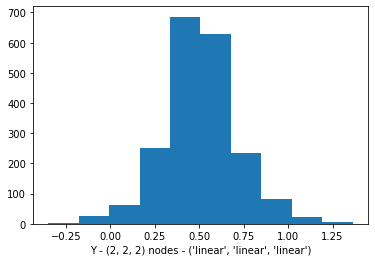

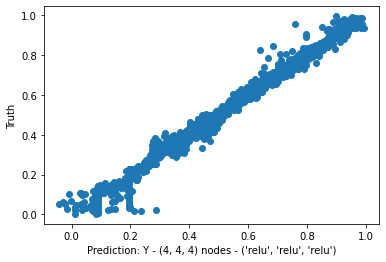

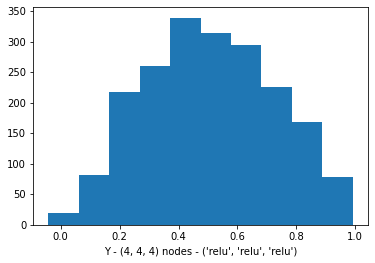

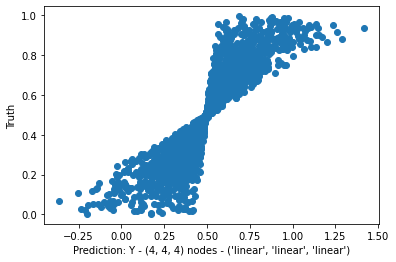

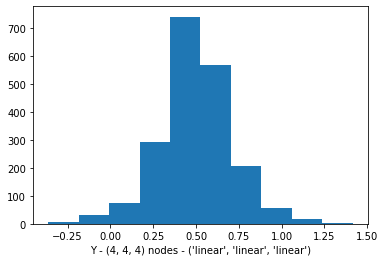

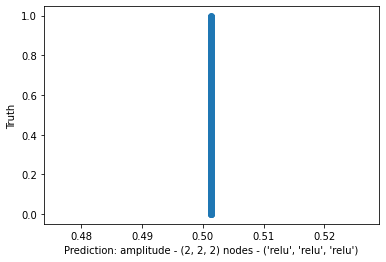

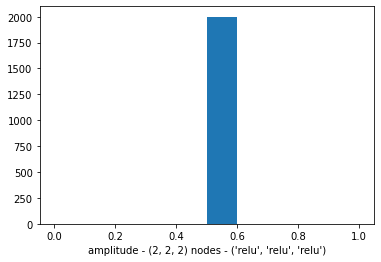

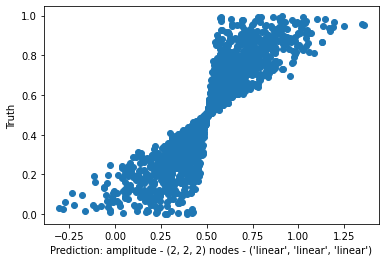

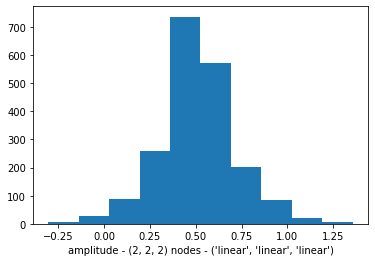

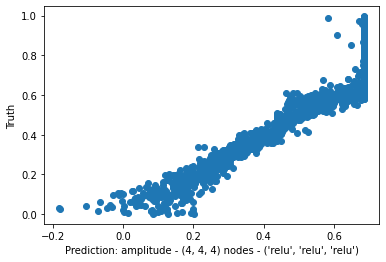

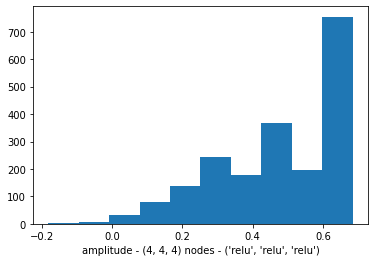

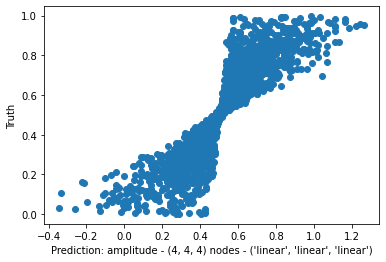

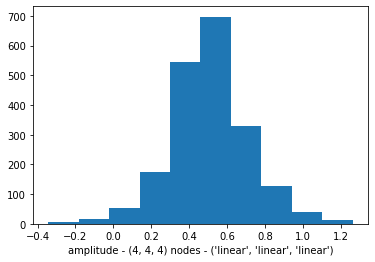

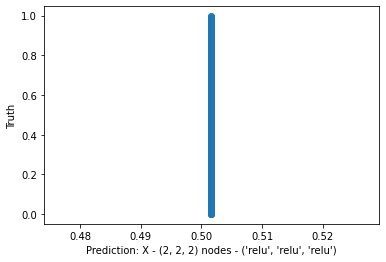

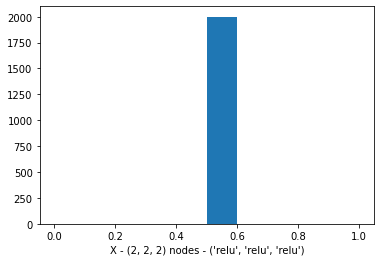

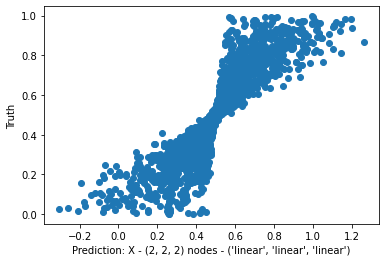

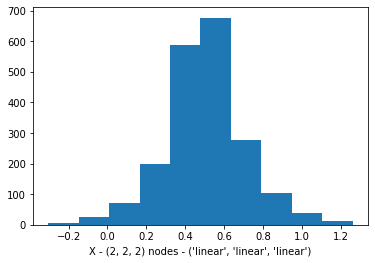

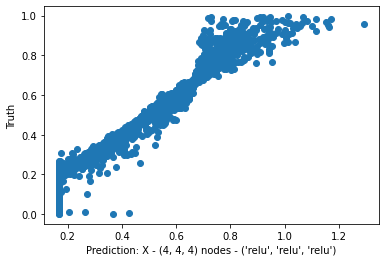

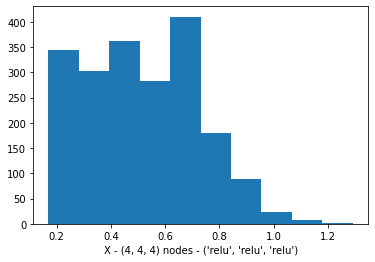

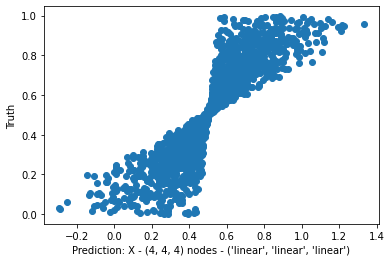

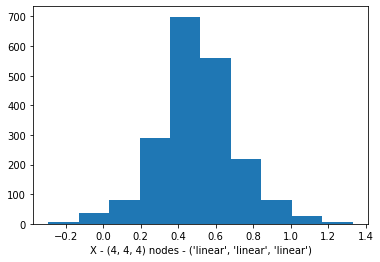

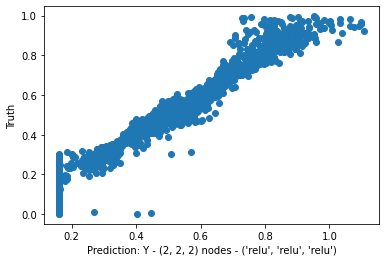

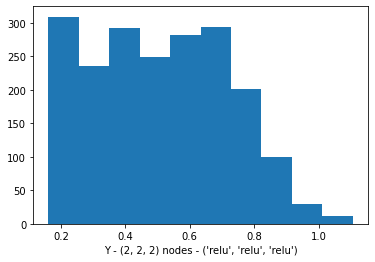

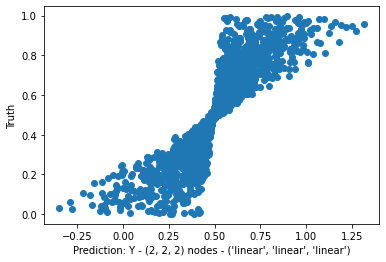

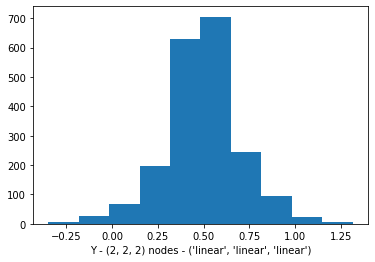

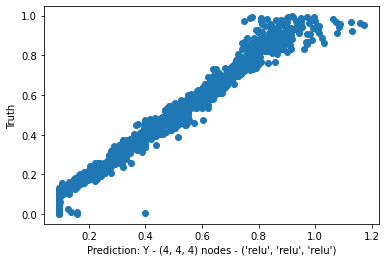

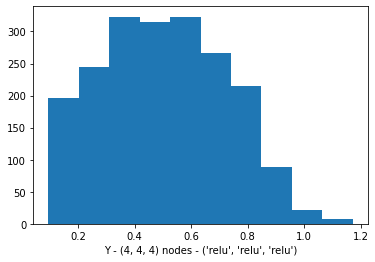

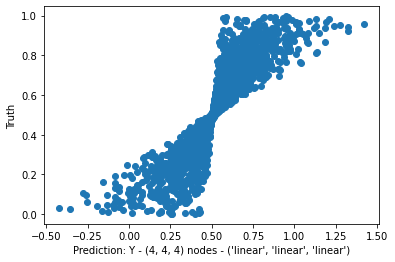

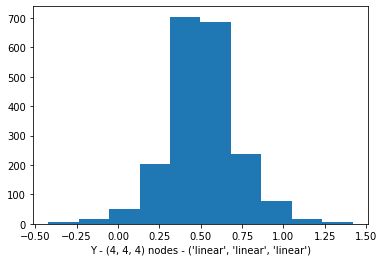

In [ ]:
# define early stopping monitor for callback for early stopping and restoring best weights.
# useful if you increase the number of epochs in lst_epochs
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=False,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

# create lists for hyperparameters we are interested in
# I kept this small for the sake of time
target_indxs = [0,1,2] # amplitude, X, Y
target_names = ['amplitude','X','Y']
num_nodes = [(2,2,2),(4,4,4)]
activations = [('relu','relu','relu'),('linear','linear','linear')]
learning_rates = [1e-3]
batch_sizes = [64]
epochs = [10] # set small for demo purposes

# loop through grid search of parameters
#i in range(0,3): # index 0 == amplitude. For amplitude,X,andY, range(0,3)
#n in lst_num_nodes:
#a in lst_activations:
#lr in lst_learning_rates:
#b in lst_batch_sizes
#e in lst_epochs:
for i, t, n, a, lr, b, e in [[i,t,n,a,lr,b,e] for i in target_indxs for t in target_names for n in num_nodes for a in activations for lr in learning_rates for b in batch_sizes for e in epochs]:
  # create the model
  model = create_sequential_dnn(900, num_nodes=n, activations=a, outputs=1)
  # Adam optimizer
  opt = Adam(learning_rate=lr)
  model.compile(loss="mse", optimizer=opt)

  # start mlflow run
  with mlflow.start_run():

    # log to mlflow the parameters for the run
    # we can log multiples by creating a dictionary, or log individually like we do metrics below
    mlparams = {"model_type": "Sequential",
            "target": t,
            "num_nodes": str(n),
            "activations": str(a),
            "learning_rate": str(lr),
            "num_epochs": str(e),
            "batch_size": str(b),
            }
    mlflow.log_params(mlparams)

    # save the time training begins
    start = time.time()

    # sequential network - feel free to add elements
    model.fit(x=df_train_X, y=scaled_train_y[:,i],
        validation_data=(df_test_X, scaled_test_y[:,i]),
        epochs=e, batch_size=b, callbacks=[early_stopping_monitor])

    # log the time to train metric
    mlflow.log_metric("time_to_train", time.time() - start)

    print("[INFO] predicting...")
    # save the time predicting begins
    start = time.time()
    preds = model.predict(df_test_X)

    # log the prediction metrics on test set
    # we can log these individual (or use the dictionary method used above for the params)
    mlflow.log_metric("time_to_predict", time.time() - start)
    mlflow.log_metric("mae", np.mean(np.abs(scaled_test_y[:,i] - preds.flatten())))
    mlflow.log_metric("mse", np.mean(((scaled_test_y[:,i] - preds.flatten()))**2))

    # plot truth v pred and save the plt to mlflow artifacts
    fig, ax = plt.subplots()
    ax.scatter(preds, scaled_test_y[:,i])
    ax.set_xlabel(f'Prediction: {t} - {n} nodes - {a}')
    ax.set_ylabel('Truth')
    mlflow.log_figure(fig, "truth_v_pred.png")
    # could also use log artifacts: https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.log_artifact

    fig, ax = plt.subplots()
    ax.hist(preds)
    ax.set_xlabel(f'{t} - {n} nodes - {a}')
    mlflow.log_figure(fig, "pred_distribution.png")




##### While this is running
1. Take a look into the directories in the mlruns directory
  * each is for one of the "runs"
  * within each is a directory for:
    * artifacts (contains the plots)
    * metrics
    * params

#### Comparing results

In [ ]:
# select by experiment id(s)
df = mlflow.search_runs(experiment_ids=experiment.experiment_id)
# here I filter and sort to get the lowest loss first
df = df.sort_values(by=['metrics.mse','params.target'], ignore_index=True)
df.head(10)

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.mse,metrics.time_to_predict,metrics.mae,metrics.time_to_train,params.learning_rate,params.activations,params.target,params.num_epochs,params.batch_size,params.model_type,params.num_nodes,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.user
0,cae769853bab47bfa03edfb2476e0485,748261366657569442,FINISHED,file:///content/mlruns/748261366657569442/cae7...,2023-03-04 16:43:50.436000+00:00,2023-03-04 16:44:03.402000+00:00,0.000130,1.092412,0.005998,11.461201,0.001,"('linear', 'linear', 'linear')",Y,10,64,Sequential,"(2, 2, 2)",/usr/local/lib/python3.8/dist-packages/ipykern...,LOCAL,ambitious-deer-161,root
1,7483bfa867a94146a1448bfc00be9d2b,748261366657569442,FINISHED,file:///content/mlruns/748261366657569442/7483...,2023-03-04 16:42:04.448000+00:00,2023-03-04 16:42:15.174000+00:00,0.000132,0.626118,0.006454,9.849361,0.001,"('linear', 'linear', 'linear')",amplitude,10,64,Sequential,"(2, 2, 2)",/usr/local/lib/python3.8/dist-packages/ipykern...,LOCAL,legendary-snail-920,root
2,0b7dbf2a5e17472c93b2f2e36cf80cde,748261366657569442,FINISHED,file:///content/mlruns/748261366657569442/0b7d...,2023-03-04 16:43:03.583000+00:00,2023-03-04 16:43:14.483000+00:00,0.000153,0.646655,0.006466,10.003015,0.001,"('relu', 'relu', 'relu')",X,10,64,Sequential,"(4, 4, 4)",/usr/local/lib/python3.8/dist-packages/ipykern...,LOCAL,capable-boar-637,root
3,95d05f2df064470188abd40d45422a7d,748261366657569442,FINISHED,file:///content/mlruns/748261366657569442/95d0...,2023-03-04 16:44:03.489000+00:00,2023-03-04 16:44:17.748000+00:00,0.000154,1.677715,0.006437,12.227167,0.001,"('relu', 'relu', 'relu')",Y,10,64,Sequential,"(4, 4, 4)",/usr/local/lib/python3.8/dist-packages/ipykern...,LOCAL,efficient-auk-796,root
4,7acf5d724a494dddb4f9eb787568d7bf,748261366657569442,FINISHED,file:///content/mlruns/748261366657569442/7acf...,2023-03-04 14:27:33.009000+00:00,2023-03-04 14:27:45.199000+00:00,0.000160,0.611020,0.007889,11.334207,0.001,"('linear', 'linear', 'linear')",amplitude,10,64,Sequential,"(4, 4, 4)",/usr/local/lib/python3.8/dist-packages/ipykern...,LOCAL,handsome-ant-478,root
5,85d411b09945453ca6b85c0c67dd1de7,748261366657569442,FINISHED,file:///content/mlruns/748261366657569442/85d4...,2023-03-04 14:29:04.042000+00:00,2023-03-04 14:29:16.967000+00:00,0.000160,1.016424,0.007101,11.505682,0.001,"('relu', 'relu', 'relu')",Y,10,64,Sequential,"(4, 4, 4)",/usr/local/lib/python3.8/dist-packages/ipykern...,LOCAL,nebulous-shoat-728,root
6,9bf5b9724dcd4b799eed1b5fd4075c72,748261366657569442,FINISHED,file:///content/mlruns/748261366657569442/9bf5...,2023-03-04 16:41:51.269000+00:00,2023-03-04 16:42:04.365000+00:00,0.000165,1.127347,0.006109,11.572356,0.001,"('relu', 'relu', 'relu')",amplitude,10,64,Sequential,"(2, 2, 2)",/usr/local/lib/python3.8/dist-packages/ipykern...,LOCAL,dashing-sloth-951,root
7,8d07ba3781e5485f8d8574f921fc7988,748261366657569442,FINISHED,file:///content/mlruns/748261366657569442/8d07...,2023-03-04 14:28:36.989000+00:00,2023-03-04 14:28:50.593000+00:00,0.000172,1.113585,0.006461,12.093154,0.001,"('relu', 'relu', 'relu')",Y,10,64,Sequential,"(2, 2, 2)",/usr/local/lib/python3.8/dist-packages/ipykern...,LOCAL,salty-bird-379,root
8,3997489452174896984fa9d34218e0b7,748261366657569442,FINISHED,file:///content/mlruns/748261366657569442/3997...,2023-03-04 14:27:08.766000+00:00,2023-03-04 14:27:22.404000+00:00,0.000172,1.056402,0.007453,12.345073,0.001,"('linear', 'linear', 'linear')",amplitude,10,64,Sequential,"(2, 2, 2)",/usr/local/lib/python3.8/dist-packages/ipykern...,LOCAL,valuable-snail-189,root
9,104df0560470408aae93d4f4982b14b6,748261366657569442,FINISHED,file:///content/mlruns/748261366657569442/104d...,2023-03-04 16:44:17.825000+00:00,2023-03-04 16:44:30.962000+00:00,0.000173,0.628144,0.007288,12.275672,0.001,"('linear', 'linear', 'linear')",Y,10,64,Sequential,"(4, 4, 4)",/usr/local/lib/python3.8/dist-packages/ipykern...,LOCAL,bustling-rook-663,root


**What does this look like on the MLflow server?**

<img src='https://lh3.googleusercontent.com/OZw8jEMO4t9dBcCsmWzwiB0koeJZ-r9tXWRSjRKHgdhhht0wFAlxzeIqYxJpEvrxNCo=w2400' />
<center>Screenshot from JLab's dev MLflow server. Experiment list is shown on left, and the selected experiment is shown in main webpage area. All the runs saved to the experiment are shown in a sortable and filterable list. An individual run can be selected...</center>
<br />
<br />

<img src='https://lh6.googleusercontent.com/3NM1iDVlgEsSJR_qZqrVL4xPjjW06-h57WRbbeOf994mL9RY0oTwNvYhxE_mWT336lM=w2400' width="600"/>
<image src='https://lh6.googleusercontent.com/EJMizuMz6MaRHNgJgNNotOwYAKA4nwVzMlDvuBfd-rvQI_taKl0PHtFFGwg9ZKVvgKk=w2400' width="500"/>
<center>Screenshots from JLab's dev MLflow server for run 8465783c3c2... run. Mode parameters, metrics, tags and artifacts are shown. Figures can also be viewed on the webpage.
</center>
<br />
<br />

---



In [ ]:
# this code is here so I can pause and talk without the Colab session disconnecting
#while True:pass

## Your turn: Grid Search over CNN parameters

**Tasks**
1. create a new mlflow experiment with the name "mlflow_tutorial_calorimeter_amplitude_grid_search_CNN"
1. Grid search for the an amplitude predicting model. Try:
  1. 2 filter options
  1. 2 activation options
  1. 2 dropout options
1. compare the results in a dataframe, sorted by

In [ ]:
# TODO: Do a grid search over two selections of filters and activation functions for the CNN

# TODO: Save the results to your mlflow experiment - remember to set the parameter "model_type" to "CNN"

In [ ]:
# TODO: Compare the results. What are the parameters for your best performing CNN?

## Pause: Hyperparameter Optimization, is there a better way?

Most basic description: Find the model hyperparameters that minimize loss.


#### Hyperopt

* Hyperopt's getting started: https://hyperopt.github.io/hyperopt/getting-started/overview/

* fmin: defining the function to optimize (minimize) https://github.com/hyperopt/hyperopt/wiki/FMin
* search space of each hyperparameter
* search algorithm to use
  *  Hyperopt support three algorithms for hyperparameter tuning:
        1. <a href='https://www.jmlr.org/papers/v13/bergstra12a.html' target="_new">Random Search</a>
        1. **<a href='https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf' target="_new">Tree of Parzen Estimators (TPE)</a>**
          * Bayesian optimization
          * Maximize expected information
        1. Adaptive TPE
* **Trials** the default hyperopt data store for hyperparameter performance.

##### Import hyperopt libraries we will use

In [ ]:
# Hyperopt libraries used for hyper-parameter optimization.
# http://hyperopt.github.io/hyperopt/
# fmin: sets up function to minimize (i.e. loss)
# tpe: Tree-structured Parzen Estimator <https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf>
# hp: hyperparameter
# Trials: by passing in a trials object directly to the fmin function, we can inspect all of the return values that were calculated during the experiment - instead of just a single loss value
# STATUS_OK: one of the keys from hyperopt.STATUS_STRINGS
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

### Simple example:
#### Minimizing a function with a single variable
(a more detailed simple example is here: https://github.com/hyperopt/hyperopt/blob/master/tutorial/01.BasicTutorial.ipynb)

In [ ]:
# define the search space
small_search_space = hp.uniform('x', -10, 10)

small_search_space defines the search space for the x variable.

Available functions related to search space definitions are:

* hp.randint(label, upper) - 0 is the inclusive lower bound
* hp.uniform(label, low, high)
* hp.loguniform(label, low, high)
* hp.normal(label, mu, sigma)
* hp.lognormal(label, mu, sigma)
* hp.quniform(label, low, high, q)
* hp.qloguniform(label, low, high, q)
* hp.qnormal(label, mu, sigma, q)
* hp.qlognormal(label, mu, sigma, q)
* hp.choice(label, list)
* hp.pchoice(label, p_list) with p_list as a list of (probability, option) pairs
* hp.uniformint(label, low, high, q) or hp.uniformint(label, low, high) since q = 1.0

In [ ]:
# optimize x^2 over our search space using the tpe algorithm. Try 100 evaluations
best = fmin(fn=lambda x: x ** 2,
    space=small_search_space,
    algo=tpe.suggest,
    max_evals=100)

# print the best x
print(best)


100%|██████████| 100/100 [00:00<00:00, 376.92it/s, best loss: 0.0005867495204207406]
{'x': 0.024222913128291168}


Run the above code block a couple of times. Try a different simple function with a single parameter.

### Slightly less simple example: multiple parameters

In [ ]:
# create our search space
search_space = [
    hp.uniform('x', -10, 10),
    hp.uniform('y', -2, 2),
    hp.choice('z',[2,4,6,8,10,12])
]

In [ ]:
# create our function to minimize - we will call it train, just to get in the mood for machine learning
#x^2+y^2−6z-3x+20y
def train(params):
  try:
    #print(params)
    x, y, z = params
    #print('x: {}, y: {}, z: {}'.format(x,y,z))
  except Exception as e:
    print(e)
  return {'loss': x**2 + y**2 - (6*z) - (3*x) + (20*y) , 'status': STATUS_OK}

In [ ]:
best = fmin(fn=train,
    space=search_space,
    algo=tpe.suggest,
    max_evals=5)
print(best)

100%|██████████| 50/50 [00:00<00:00, 91.70it/s, best loss: -98.955866775374]
{'x': 2.882390962734375, 'y': -1.433604699129492, 'z': 5}


## Now we need to put MLflow together with hyperopt

Need to:
* Do HPO for the CNN using hyperopt
  * create a new experiment
  * fmin function
  * create the search space of hyperparameters
  * do hyperopt training to determine the best parameters


In [ ]:
# TODO: create a new experiment with a different name
new_experiment_name = ""

In [ ]:
# TODO: create our minimization function == training the model
def train(params):

  # use mse for accuracy metric
  mse = 0
  return {'loss': mse, 'status': STATUS_OK}

In [ ]:
# TODO: create the search space of hyperparameters

In [ ]:
# TODO: do hyperopt training - remember to log to your new MLflow experiment

In [ ]:
# display training results and determine your best hyperparameters

# Where can you go from here with respect to hyperparameter optimization and tracking model architecture performance:
* Parallelizing Evaluations During hyperopt Search via MongoDB: https://hyperopt.github.io/hyperopt/scaleout/mongodb/
* Keras Tuner for tensorflow: https://www.tensorflow.org/tutorials/keras/keras_tuner
